# Bayesian Covariance Model

by Max Margenot & Thomas Wiecki

## Portfolio Optimization

Creating an "optimal" portfolio for a given set of assets is a key problem in quantitative finance. Given a potentially massive universe of securities available to trade, what is the best way to combine these assets, or some subset of them? 

Expressing this selection of weights as an optimization problem allows us to easy find the right weights given an objective function (i.e. what we mean by optimal) as well as constraints (leverage or exposure to certain risk factors).

### Markowitz Portfolio Optimization

Markowitz portfolio optimization is the classical form of the problem, developed by Harry Markowitz in 1952. This optimization problem is a cornerstone of [Modern Portfolio Theory](https://en.wikipedia.org/wiki/Modern_portfolio_theory) (MPT). Markowitz portfolio optimization and MPT lead to key ideas in finance, such as the [efficient frontier](https://en.wikipedia.org/wiki/Efficient_frontier) and the importance of combining uncorrelated assets to create more effective portfolios. Perhaps not surprisingly, Markowitz received the Nobel Prize in Economics for his theory. The importance of combining assets is codifed in the optimization problem itself. We express this problem as an objective with a set of constraints, as follows:

\begin{equation*}
\begin{aligned}
& \underset{\omega} {\text{minimize}}
& & \omega^\top\Sigma\omega - R^\top\omega \\
& \text{subject to}
& & \sum_{i=1}^N \omega_i = 1
\end{aligned}
\end{equation*}

where $R = [R_1, \dots, R_N]$ is the expected returns of each asset $S_i$, with covariance matrix $\Sigma$, $N\times N$:

$$ \Sigma = \left[\begin{matrix}
VAR(R_1) & COV(R_1, R_2) & \cdots & COV(R_1, R_N) \\
COV(R_2, R_0) & VAR(R_2) & \cdots & COV(R_2, R_N) \\
\vdots & \vdots & \ddots & \vdots \\
COV(R_N, R_1) & COV(R_N, R_2) & \cdots & VAR(R_N)
\end{matrix}\right] $$

 The vector $\omega = [\omega_1, \dots, \omega_N]$ is the weight vector, where each $\omega_i$ corresponds to the percentage of the portfolio that is allocated to asset $S_i$. These weights, as specified here, can be either positive or negative, as long as they sum up to $1$.

The covariance matrix quantifies the relationships between different assets in the portfolio, allowing us to examine how much of the variance of one asset can be explained by the variance of another. In the solution of the optimization problem, assets with high correlation are collectively weighted less. Because they are correlated, they are considered closely related and, thus, interchangeable. Down-weighting related assets improves the portfolio by making sure that no individual "bet" is given too much importance. For more information on why we care about independent assets, check out [these](https://www.quantopian.com/lectures/position-concentration-risk) [lectures](https://www.quantopian.com/lectures/estimating-covariance-matrices) [from](https://www.quantopian.com/lectures/why-you-should-hedge-beta-and-sector-exposures-part-i) [the](https://www.quantopian.com/lectures/why-you-should-hedge-beta-and-sector-exposures-part-ii) [Quantopian Lecture Series](https://www.quantopian.com/lectures).

While the theory is beautiful and expresses exactly what an investor would want (maximize returns while minimizing risk) it often fails when naively applied. Specifically, we do not know the true values of $R$ and $\Sigma$, so we have to estimate them on data. Unfortunately, while this is simple in practice it is a tricky problem because our estimates tend to be very unstable. This instability in turn leads to very unstable weight estimates and often causes the portfolio weights to be very concentrated and jump around a lot between every rebalance, ramping up huge transaction costs. Several solutions have been proposed like instead using inverse-volatility weighting which ignores the mean and correlation, or [Lopez de Prado's hierarchical risk parity](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678). Here, we will instead try to make the original Markowitz approach work taking uncertainty in our estimates into account. 

## Uncertainty in Covariance

Because estimating the covariance accurately is so important for certain kinds of portfolio optimization, a lot of literature has been dedicated to developing stable ways to estimate the true covariance between assets. The goal of this post is to describe a Bayesian way to think about covariance.

A natural way to account for erratic covariance is to attempt to quantify the uncertainty involved in any given estimate. If we can take this uncertainty into account when performing portfolio optimization, then we should be able to better express how confident we are in any individual bet. With a better estimate of the uncertainty for any given calculated relationship between assets, we can better apportion our capital for optimal results. To quantify this uncertainty, we turn to Bayesian statistics and probabilistic programming.

## Time-changing correlations

Another problem with estimating correlations in quant finance is that they change over time. Usually people re-fit the correlation matrix over a moving window. However, because estimating correlation structure is so noisy, restricting the number of data points in a window is very detrimental on estimation accuracy.

Here, we will show how a Random-Walk distribution can be placed on the elements of the covariance matrix allowing correlations to change over time (see this [previous blog post](https://blog.quantopian.com/probabilistic-programming-quant-finance/) for more details on this trick.

### Bayesian Statistics

Bayesian statistics is a statistical framework for quantifying uncertainty in the form of probability distributions. Within this framework, we express the parameters we are curious about, $\theta$, as random variables. These random variables that we begin with are called our priors, and, through Bayes' rule, we can incorporate observed data, $\mathbf{X}$, into our model to adapt our initial impressions of how these parameters actually behave, our posterior distribution.

We express Bayes' rule like so:

$$ P(\theta\ |\ \mathbf{X}) = \frac{P(\mathbf{X}\ |\ \theta)\  P(\theta)}{P(\mathbf{X})} \propto P(\mathbf{X}\ |\ \theta)\  P(\theta) $$

where $P(\theta\ |\ \mathbf{X})$ is our posterior distribution, $P(\mathbf{X}\ |\ \theta)$ is the likelihood of the model, and $P(\theta)$ is our prior distribution.

### Probabilistic Programming

Probabilistic programming is a tool that helps us implement this problem in a Bayesian framework using code. Calculating the posterior distribution analytically can be thorny, but, with advances in numerical computation, we can approximate the distributions that we want by defining our priors and our likelihood and letting our sampling methods loose on the problem.

With this in mind, we set the following priors for our returns and covariance matrix:

\begin{eqnarray*}
    R &\sim& MvNormal(0, \Sigma) \\
    L &\sim& \exp[GaussianRandomWalk(0, 0.1)]\\
    \Sigma &=& LL^\top
\end{eqnarray*}

where $\Sigma = LL^\top$ is the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$. Note that we allow the Cholesky factors to vary over time which translates to the covariance matrix to change over time.

## The Model

Our goal is to represent the covariance matrix of a set of assets as a probability distribution, or, a set of probability distributions.

In [55]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
from quant_utils import market_data_loader
get_pricing = market_data_loader.get_panel

/mnt/efs/home/mmargenot/miniconda2/envs/mmargenot/lib/python3.5/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


Before we begin building the model, we need to select a trading universe. Here we selected a set of 17 ETFs, most of which were examined in Thomas Wiecki's post on [Hierarchical Risk Parity](https://www.quantopian.com/posts/hierarchical-risk-parity-comparing-various-portfolio-diversification-techniques).

In [3]:
symbols = [u'EEM', u'EWG', u'EWJ', u'EFA', u'EWQ', 
           u'EWU', u'XLB', u'XLE', u'XLF', u'XLK',
           u'XLU', u'EPP', u'FXI', u'VGK', u'VPL',
           u'SPY', u'DIA']

rets = (get_pricing(symbols,  
                    start_date='2014-01-01',
                    end_date='2016-07-01',
                    frequency='1d'
                   )
        .pct_change()['close'][1:]
        .rename(columns=lambda x: x.symbol)
)

/mnt/efs/home/mmargenot/miniconda2/envs/mmargenot/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


In [4]:
rets.head()

,EEM,EWG,EWJ,EFA,EWQ,EWU,XLB,XLE,XLF,XLK,XLU,EPP,FXI,VGK,VPL,SPY,DIA
2014-01-03 00:00:00+00:00,-0.002594,-0.003562,0.005020,0.000608,-0.003961,0.000000,-0.002086,-0.003216,0.005975,-0.005208,-0.002946,0.002374,-0.012402,0.000172,0.003227,-0.000874,0.001277
2014-01-06 00:00:00+00:00,-0.009590,0.004581,-0.002498,-0.000755,-0.001443,-0.002926,-0.005673,0.000920,0.000910,-0.001576,0.000790,-0.004521,-0.017197,0.000536,-0.003726,-0.002134,-0.002551
2014-01-07 00:00:00+00:00,0.004271,0.004214,0.004144,0.005308,0.007263,0.004652,-0.001663,0.007930,0.000479,0.008818,0.009384,0.001730,0.000295,0.006769,0.003334,0.005758,0.006220
2014-01-08 00:00:00+00:00,-0.002245,-0.002924,0.002494,-0.000147,-0.002171,-0.001709,0.005623,-0.006956,0.004113,0.000295,-0.005561,-0.002807,0.011092,-0.000703,0.000985,0.000493,-0.003396
2014-01-09 00:00:00+00:00,-0.005798,-0.002104,-0.004117,-0.000768,-0.002875,-0.001436,-0.003497,-0.003098,0.003192,-0.006495,0.006116,-0.001083,-0.017826,0.000703,-0.003794,0.000435,-0.000973


In [5]:
def expand_diag_lower(n, diag, lower):
    # helper function
    out = tt.zeros((n, n), dtype=theano.config.floatX)
    idxs = np.tril_indices(n, k=-1)
    out = tt.set_subtensor(out[idxs], lower)
    idxs = np.diag_indices(n)
    return tt.set_subtensor(out[idxs], diag)

Here we define the model in PyMC3 code.

In [6]:
def build_basic_rw_model(observations, subsample_rate=30):
    total_time, n_secs = observations.shape
    with pm.Model() as bayesian_cov:
        # make the variance
        log_var = pm.GaussianRandomWalk(
            "log_var", 
            mu=0,
            sd=.1,
            shape=(total_time//subsample_rate, n_secs),
        )
        var = tt.exp(log_var)
        
        # make the cholesky matrix
        lower_chol = pm.GaussianRandomWalk(
            "lower_chol",
            mu=0,
            sd=.1,
            shape=(total_time//subsample_rate, n_secs*(n_secs-1)//2)
        )
        cholesky = tt.as_tensor(
            [expand_diag_lower(n_secs, var[t,:], lower_chol[t,:])
                for t in range(total_time//subsample_rate)])
        
        # expand the cholesky into the covariance
        covariance = pm.Deterministic(
            'covariance',
            tt.as_tensor([cholesky[t].dot(cholesky[t].T)
                          for t in range(total_time//subsample_rate)])
        )

        # reshape the observations
        reshaped_returns = observations.values[
            :(subsample_rate*(total_time//subsample_rate))
        ].reshape(total_time//subsample_rate, subsample_rate, n_secs)
        time_segments, _, _ = reshaped_returns.shape
        
        # make the likelihood
        for t in range(time_segments):
            pm.MvNormal(
                'likelihood_{0}'.format(t),
                mu=np.zeros(n_secs),
                chol=cholesky[t,:,:],
                observed=reshaped_returns[t]
            )
    return bayesian_cov

In [7]:
subsample_rate = 30
basic_model = build_basic_rw_model(rets, subsample_rate=subsample_rate)

### Cry Havoc

Despite the complexity of this model, sampling in PyMC3 handles it well:

In [8]:
with basic_model:
    basic_trace = pm.sample(1000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lower_chol, log_var]
Sampling 2 chains: 100%|██████████| 4000/4000 [1:01:04<00:00,  1.34s/draws]
The number of effective samples is smaller than 25% for some parameters.


### Results

We look at the trace for these reasons and it tells us these things.

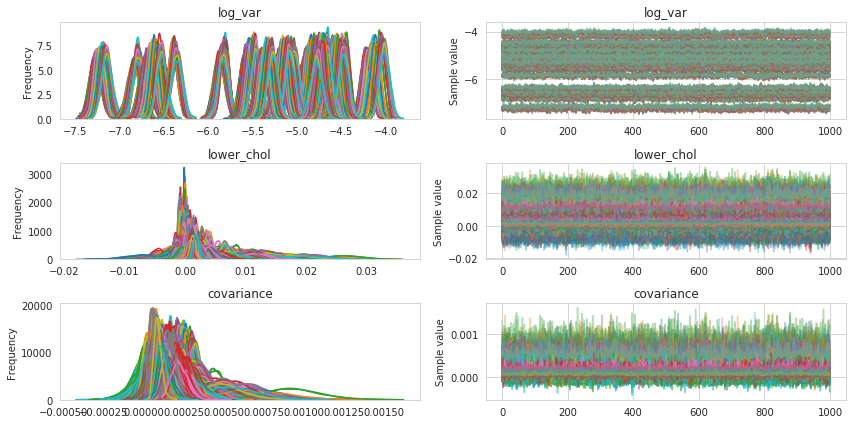

In [9]:
pm.traceplot(basic_trace);

### Diagnostics

Calculating the Gelman-Rubin statistic gives us an additional measure of convergence for our model.

In [10]:
gr_stats = pm.diagnostics.gelman_rubin(basic_trace)

In [11]:
print("Average Gelman-Rubin Statistics:")
for variable, stats in gr_stats.items():
    print("{0}: {1}".format(variable, np.mean(stats)))

Average Gelman-Rubin Statistics:
lower_chol: 1.0000496175923863
log_var: 1.0014056609265363
covariance: 1.0003739493094546


Numbers close to 1 indiciate good convergence between chains.

## Posteriors

In [12]:
posterior_covariance = basic_trace['covariance']
n_secs = posterior_covariance.shape[-2]

In [13]:
stds = np.sqrt(np.diagonal(posterior_covariance, axis1=2, axis2=3))
corr = posterior_covariance.copy()
corr[:] /= stds[:, :, :, None]
corr[:] /= stds[:, :, None, :]

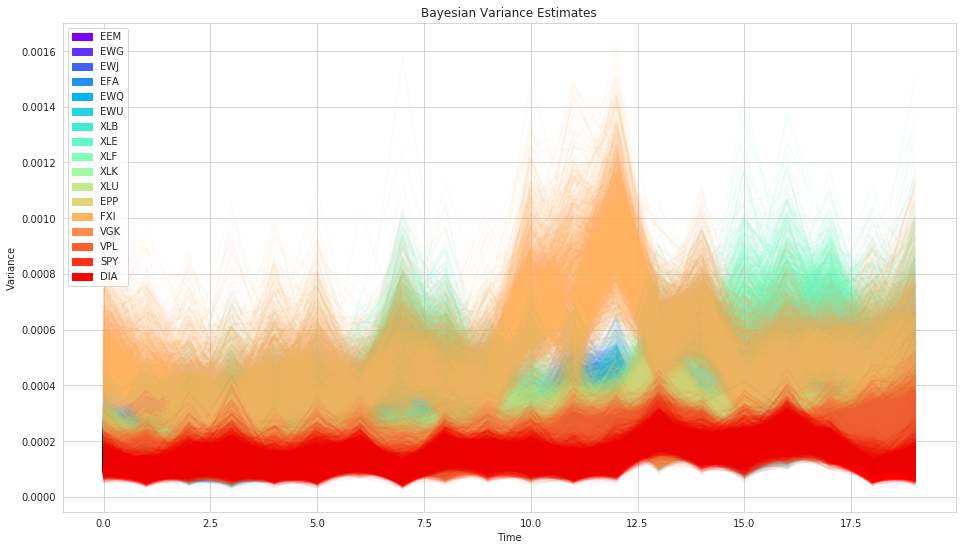

In [14]:
colors = cm.rainbow(np.linspace(0, 1, n_secs))
handles = []
plt.figure(figsize=(16, 9))
for n, c in zip(range(n_secs), colors):
    plt.plot(posterior_covariance[:, :, n, n].T, alpha=.05, color=c);
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
plt.title('Bayesian Variance Estimates')
plt.legend(handles=handles)
plt.ylabel('Variance')
plt.xlabel('Time');

As you can see, we get uncertainty into our volatility (variance) estimate for each stock (the width of the distribution) as well as allow volatility to change over time.

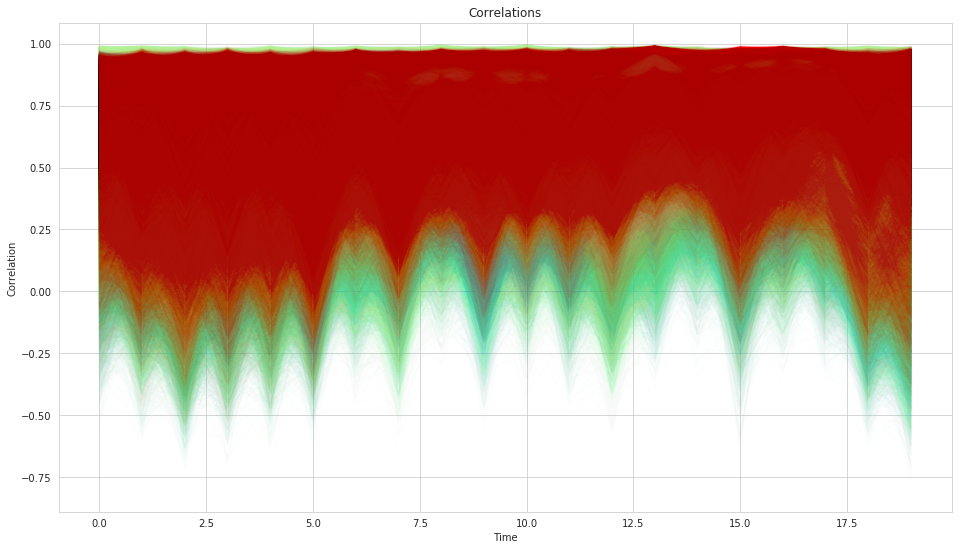

In [15]:
tri = np.tril_indices(n_secs, k=-1)
colors = cm.rainbow(np.linspace(0, 1, len(tri[0])))
handles = []
plt.figure(figsize=(16, 9))
for n, c in zip(range(len(tri[0])), colors):
    plt.plot(corr[:, :, tri[0][n], tri[1][n]].T, alpha = 0.01, color=c)
    handles.append(
        mpatches.Patch(
            color=c,
            label="({0}, {1})".format(rets.columns[tri[0][n]], rets.columns[tri[1][n]])
        )
    )
plt.title('Correlations');
#plt.legend(handles=handles)
plt.ylabel('Correlation')
plt.xlabel('Time');

What is quite striking from the correlations plot is how wide our uncertainty is which matches our general experience of correlations being very unstable. But here, rather than assuming a single value the model can communicate that its very uncertain.

To drive this point home further let's compare these results with what we would get from a classic rolling-window approach.

In [16]:
mean_corr = corr.mean(axis=0)
std_corr = corr.std(axis=0)
snr_corr = mean_corr/std_corr

In [17]:
trad_roll_corr = rets.rolling(subsample_rate, axis=0).corr(pairwise=True)[subsample_rate*len(symbols):]
trad_roll_cov = rets.rolling(subsample_rate, axis=0).cov(pairwise=True)[subsample_rate*len(symbols):]

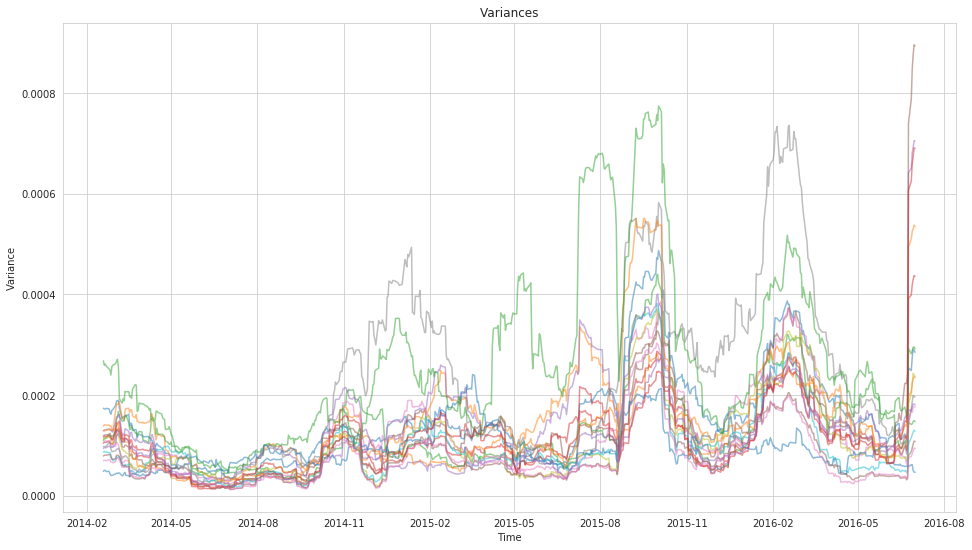

In [18]:
roll_cov_vals = trad_roll_cov.values.reshape((len(trad_roll_cov) // n_secs, n_secs, n_secs))

plt.figure(figsize=(16, 9))
for n in range(n_secs):
    plt.plot(
        trad_roll_cov.index.levels[0].values[subsample_rate:],
        roll_cov_vals[:, n, n],
        alpha=0.5
    )
plt.title('Variances')
plt.xlabel('Time')
plt.ylabel('Variance');

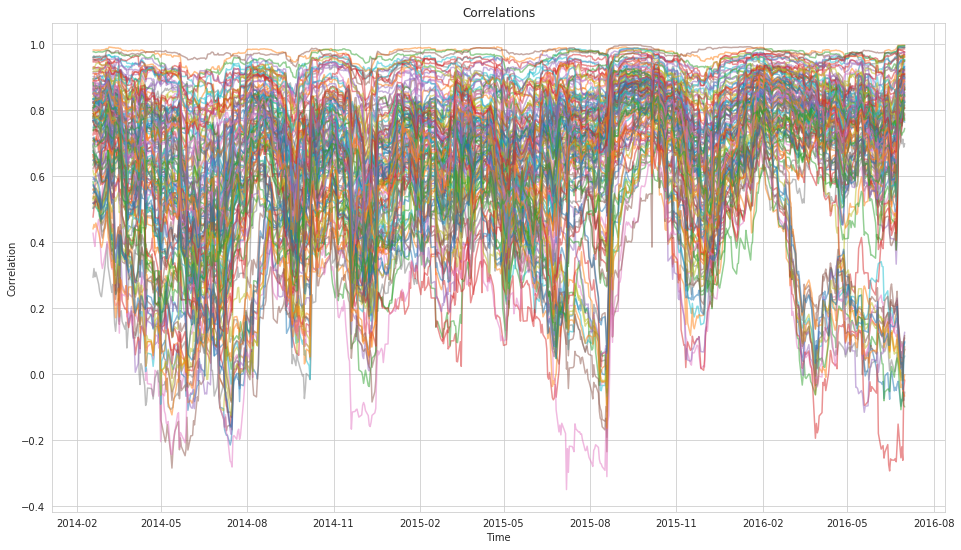

In [19]:
roll_corr_vals = trad_roll_corr.values.reshape((len(trad_roll_corr) // n_secs, n_secs, n_secs))

plt.figure(figsize=(16, 9))
tri = np.tril_indices(n_secs, k=-1)
for n in range(len(tri[0])):
    plt.plot(
        trad_roll_corr.index.levels[0][subsample_rate:],
        roll_corr_vals[:,tri[0][n], tri[1][n]],
        alpha=0.5
    )
plt.title('Correlations')
plt.xlabel('Time')
plt.ylabel('Correlation');

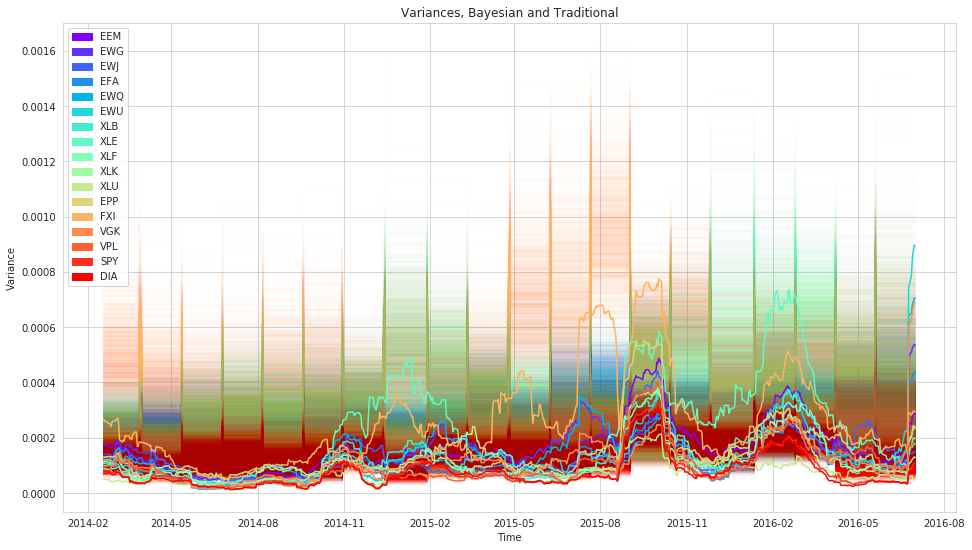

In [20]:
plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, n_secs))
handles = []
for n, c in zip(range(n_secs), colors):
    plt.plot(
        trad_roll_cov.index.levels[0][subsample_rate:],
        np.repeat(posterior_covariance, repeats=subsample_rate, axis=1)[:,1:,n,n].T,
        alpha = 0.01,
        color = c
    )
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
    
for n, c in zip(range(n_secs), colors):
    plt.plot(
        trad_roll_cov.index.levels[0][subsample_rate:],
        roll_cov_vals[:, n, n],
        alpha = 1.0,
        color=c
    )
    
plt.title('Variances, Bayesian and Traditional')
plt.legend(handles=handles)
plt.xlabel('Time')
plt.ylabel('Variance');

In [21]:
i = 5

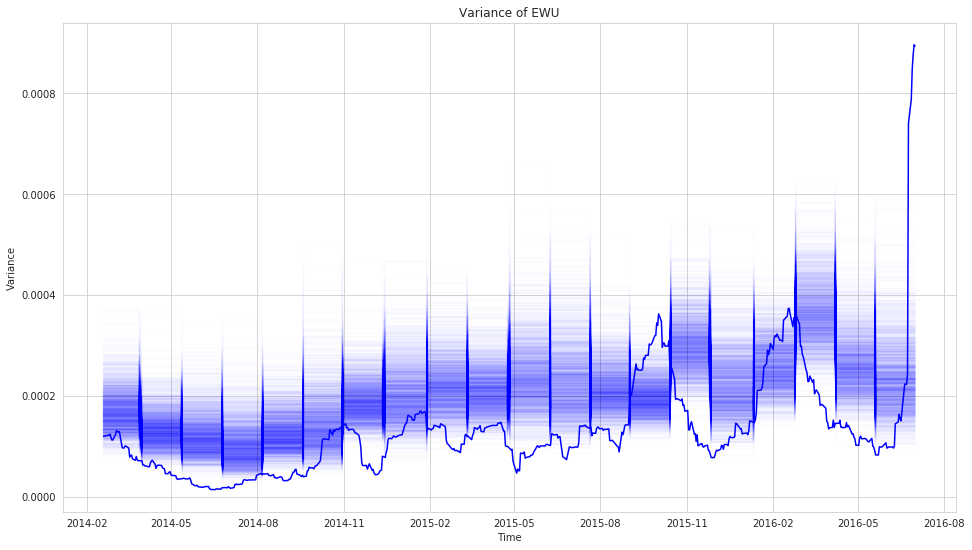

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(
    trad_roll_cov.index.levels[0][subsample_rate:],
    np.repeat(posterior_covariance, repeats=subsample_rate, axis=1)[:,1:,i,i].T,
    alpha = 0.01,
    color='blue'
)
plt.plot(
    trad_roll_cov.index.levels[0][subsample_rate:],
    roll_cov_vals[:, i, i],
    alpha = 1.0,
    color='blue'
)
plt.title('Variance of {0}'.format(rets.columns[i]))
plt.xlabel('Time')
plt.ylabel('Variance');

## Portfolio Construction

What influence does this new estimation technique have on the eventual portfolio construction? Here we are performing mean-variance on the moving-window weights as well as the values from the Bayesian posterior.

In [23]:
import cvxpy
from tqdm import tqdm, trange

In [24]:
# Mean-Variance Optimization
def get_markowitz_weights(mu, Sigma, max_position=0.50, max_leverage=1.0, short=True):
    """ Obtain the Markowitz optimization weights for a given set of mean returns
    and covariance matrix.
    
    Parameters
    ----------
    mu : ndarray
        input array of returns
    Sigma : ndarray
        covariance matrix
    max_position : float, optional
        the maximum weight allowed for a position in any individual security
    max_leverage : float, >0, optional
        the maximum leverage allowed in the portfolio
    short : bool, optional
        allow negative positions
        
    Returns
    -------
    w : ndarray
        optimal weights for set of inputs"""
    w = cvxpy.Variable(len(Sigma))
    L = cvxpy.Parameter()
    L.value = max_leverage
    try:
        ret = mu.T*w
    except ValueError:
        ret = mu*w
    
    risk = cvxpy.quad_form(w, Sigma)
    
    objective = cvxpy.Maximize(ret - risk)
    constraints = [
        cvxpy.abs(w) <= max_position,
        cvxpy.norm(w, 1) <= L, # Make it so we don't have to invest everything
    ]
    
    if not short:
        constraints.append(w >= 0) # Force all positive weights
    
    prob = cvxpy.Problem(
        objective,
        constraints
    )
    
    result = prob.solve()
    
    return w.value

In [25]:
def get_posterior_markowitz_weights(mu, Sigma, max_position=1.0, max_leverage=1.0, short=True):
    """ Obtain the Markowitz optimization weights for a posterior distribution of
    covariance matrices, given a set of mean returns and a posterior distribtuion.
    
    Parameters
    ----------
    mu : ndarray
        input array of returns
    Sigma : ndarray
        covariance matrix distribution, Samples x Time x N x N
    max_position : float, optional
        the maximum weight allowed for a position in any individual security
    max_leverage : float, >0, optional
        the maximum leverage allowed in the portfolio
    short : bool, optional
        allow negative positions
        
    Returns
    -------
    w : ndarray
        optimal weights for set of inputs"""
    
    samples = len(Sigma)
    total_time = len(mu)
    total_time_blocks = Sigma.shape[1]
    subsample_rate = int(total_time//(total_time/float(Sigma.shape[1])))
    num_secs = Sigma.shape[3]
    
    try:
        mu_vals = mu.values
    except AttributeError:
        mu_vals = mu
    
    posterior_weights = np.zeros((samples, total_time_blocks, num_secs))
    for t in trange(1, total_time_blocks+1):
        for n in range(samples):
            current_returns = np.mean(mu_vals[((t-1)*subsample_rate):(t*subsample_rate)], axis=0)
            current_cov = Sigma[n][t-1, :, :]
            
            posterior_weights[n][t-1] = get_markowitz_weights(
                current_returns,
                current_cov,
                max_position=max_position,
                max_leverage=max_leverage,
                short=short
            ).T
    return posterior_weights

In [26]:
max_position = 1.0
max_leverage = 1.0

posterior_markowitz_weights = get_posterior_markowitz_weights(
    rets,
    posterior_covariance,
    max_position=max_position,
    max_leverage=max_leverage,
    short=True
)

100%|██████████| 20/20 [13:56<00:00, 41.81s/it]


In [27]:
min_var_returns = np.ones(rets.shape)

In [28]:
posterior_min_var_weights = get_posterior_markowitz_weights(
    min_var_returns,
    posterior_covariance,
    max_position=max_position,
    max_leverage=max_leverage,
    short=True
)

100%|██████████| 20/20 [13:42<00:00, 41.13s/it]


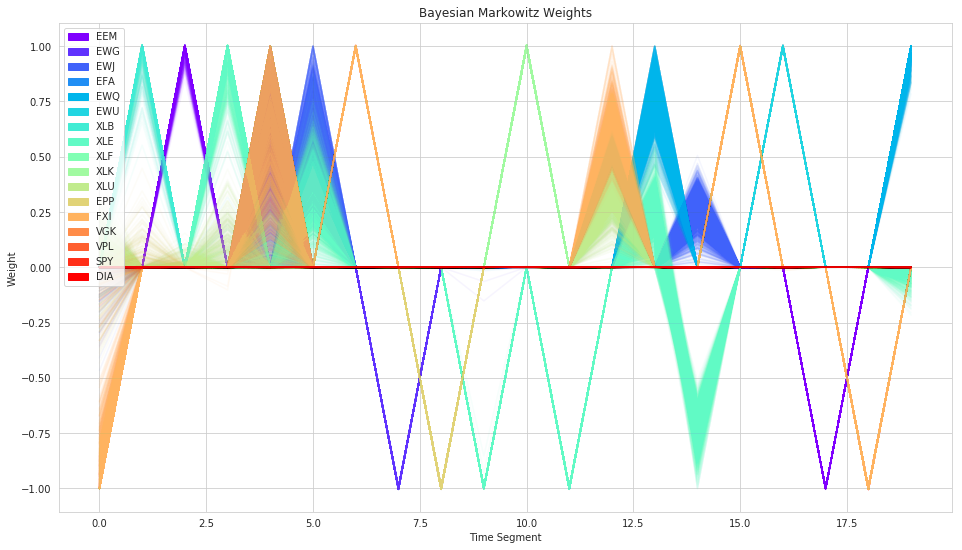

In [38]:
plt.figure(figsize=(16, 9))

colors = cm.rainbow(np.linspace(0, 1, n_secs))
handles = []
for n, c in zip(range(n_secs), colors):
    plt.plot(posterior_markowitz_weights[:, :, n].T, alpha = 0.05, color = c)
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
plt.title('Bayesian Markowitz Weights');
plt.legend(handles=handles)
plt.xlabel('Time Segment')
plt.ylabel('Weight');

As we can see, the resulting weights now have uncertainty associated to them. However, as is the tendency with Markowitz mean-variance, it is still often very concentrated on individual stocks.

Let's see if minimum-variance (taking on correlations but not mean returns into account) does any better.

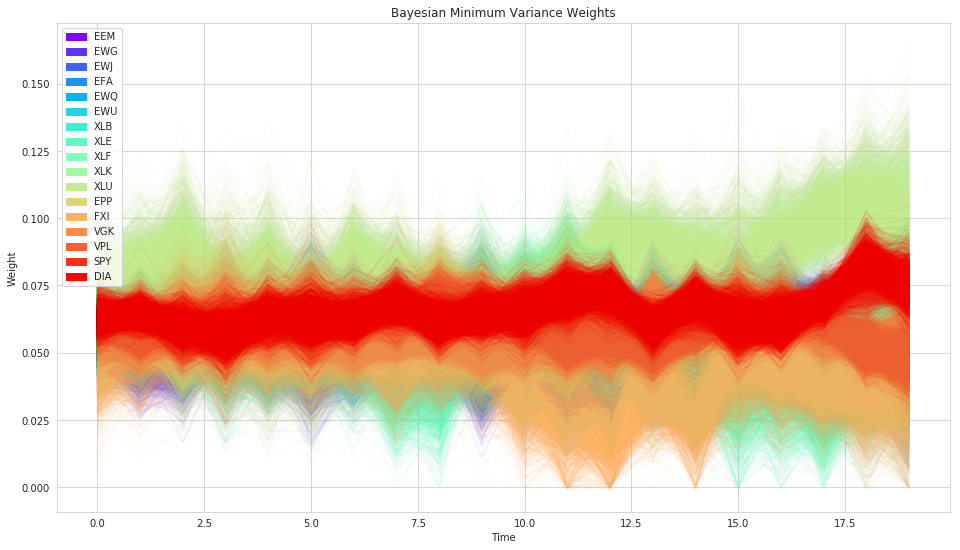

In [39]:
plt.figure(figsize=(16, 9))

colors = cm.rainbow(np.linspace(0, 1, n_secs))
handles = []
for n, c in zip(range(n_secs), colors):
    plt.plot(posterior_min_var_weights[:, :, n].T, alpha = 0.05, color=c)
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
plt.title('Bayesian Minimum Variance Weights');
plt.legend(handles=handles)
plt.xlabel('Time')
plt.ylabel('Weight');

In [31]:
# use this to compute naive markowitz weights
matched_trad_roll_cov = roll_cov_vals[:(len(rets)//subsample_rate*subsample_rate):subsample_rate]

In [32]:
trad_naive_min_var_weights = np.zeros((len(matched_trad_roll_cov), n_secs))
for t in trange(0, len(matched_trad_roll_cov)):
    trad_naive_min_var_weights[t, :] = get_markowitz_weights(
        np.ones(n_secs),
        matched_trad_roll_cov[t],
        max_position=max_position,
        max_leverage=max_leverage
    ).T

100%|██████████| 20/20 [00:00<00:00, 49.04it/s]


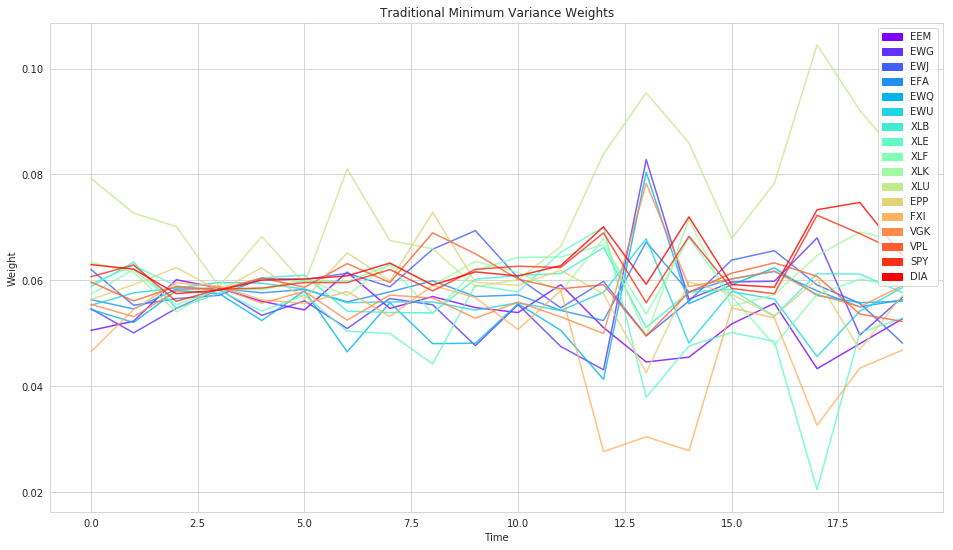

In [40]:
plt.figure(figsize=(16, 9))

colors = cm.rainbow(np.linspace(0, 1, n_secs))
handles = []
for n, c in zip(range(n_secs), colors):
    plt.plot(trad_naive_min_var_weights[:, n].T, alpha = 0.80, color=c)
    handles.append(
        mpatches.Patch(
            color=c,
            label=rets.columns[n]
        )
    )
plt.title('Traditional Minimum Variance Weights');
plt.legend(handles=handles)
plt.xlabel('Time')
plt.ylabel('Weight');

## Performance

As far as the actual performance of this optimization is routined, we care about two main things, turnover and Sharpe ratio. In order to actually use the Bayesian weights, we use the mean of the posterior distribution for a given asset's weight as the weight in the portfolio.

### Turnover
The first is the turnover of the weights from period to period. Because we expect the Bayesian covariance estimate to be a more stable reflection of the state of the relationship between all the assets in the portfolio, we hope that the turnover from period to period with the Bayesian estimate will be less than the turnover with more traditional methods. 

In [41]:
mean_posterior_min_var_weights = posterior_min_var_weights.mean(axis=0)

In [62]:
# weight is already a proportion of the overall portfolio so we can just sum
def calc_turnover(weights_over_time):
    total_time = weights_over_time.shape[0]
    turnover = np.zeros(weights_over_time.shape[0] - 1)
    for t in trange(1, total_time):
        # Total turnover at each period is the sum of whatever metric
        turnover[t-1] = np.sum(
            (weights_over_time[t, :]-weights_over_time[t-1, :])**2
        )
    return turnover

In [66]:
# weight is already a proportion of the overall portfolio so we can just sum
def calc_turnover(weights_over_time):
    total_time = weights_over_time.shape[0]
    turnover = np.zeros(weights_over_time.shape[0] - 1)
    for t in trange(1, total_time):
        # Total turnover at each period is the sum of whatever metric
        turnover[t-1] = np.mean(
            (weights_over_time[t, :] - weights_over_time[t-1, :]) / 
                weights_over_time[t-1, :]
        )
    return turnover

In [67]:
posterior_turnover = calc_turnover(mean_posterior_min_var_weights)
trad_turnover = calc_turnover(trad_naive_min_var_weights)

100%|██████████| 19/19 [00:00<00:00, 42031.53it/s]


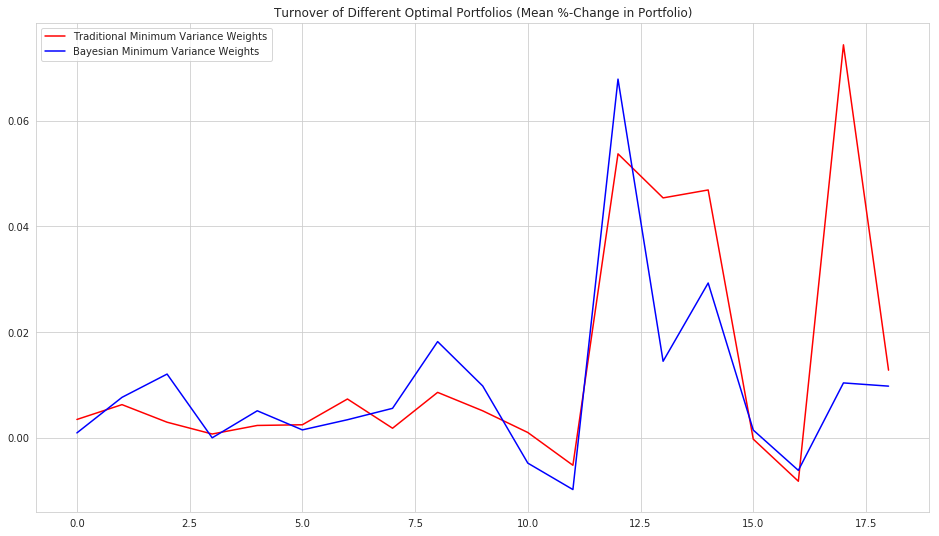

In [70]:
plt.figure(figsize=(16,9))

colors = cm.rainbow(np.linspace(0, 1, n_secs))
plt.plot(trad_turnover, color='r', label='Traditional Minimum Variance Weights')
plt.plot(posterior_turnover, color='b', label='Bayesian Minimum Variance Weights')
plt.title('Turnover of Different Optimal Portfolios (Mean %-Change in Portfolio)')
plt.legend();

It indeed seems to be the case that the Bayesian formulation of the problem leads to more stable portfolio weights.

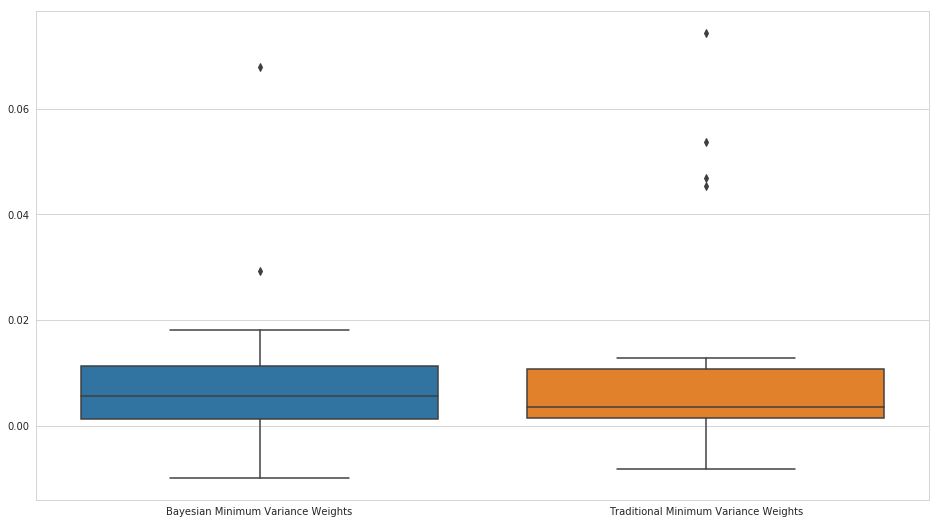

In [71]:
plt.figure(figsize=(16, 9))

sns.boxplot(
    data=pd.DataFrame(
        {'Traditional Minimum Variance Weights' : trad_turnover,
         'Bayesian Minimum Variance Weights': posterior_turnover}
    )
);

The turnover with our Bayesian portfolio is significantly lower, which should lead to a significant advantage in transaction and slippage costs over the more traditional covariance matrix formulation.

In [72]:
print('Mean Turnover:')
print('Traditional Minimum Variance Weights: ', np.mean(trad_turnover))
print('Bayesian Minimum Variance Weights: ', np.mean(posterior_turnover))

Mean Turnover:
Traditional Minimum Variance Weights:  0.013758003734391335
Bayesian Minimum Variance Weights:  0.009292716474402404


### Sharpe Ratio

In [47]:
trad_weights_df = pd.DataFrame(
    np.repeat(trad_naive_min_var_weights, subsample_rate, axis=0)[:rets[subsample_rate:].shape[0]],
    index=rets[subsample_rate:].index,
    columns=rets.columns
)
bayes_weights_df = pd.DataFrame(
    np.repeat(mean_posterior_min_var_weights, subsample_rate, axis=0)[:rets[subsample_rate:].shape[0]],
    index=rets[subsample_rate:].index,
    columns=rets.columns
)

In [48]:
trad_weight_portfolio = (rets*trad_weights_df).dropna().sum(axis=1)
bayes_weight_portfolio = (rets*bayes_weights_df).dropna().sum(axis=1)
trad_weight_portfolio.name = "Traditional Portfolio"
bayes_weight_portfolio.name = "Bayes Portfolio"

The returns of both methods seem to be about the same, though this can be misleading. If we do not account for the volatility of the two return streams, we cannot really compare them effectively.

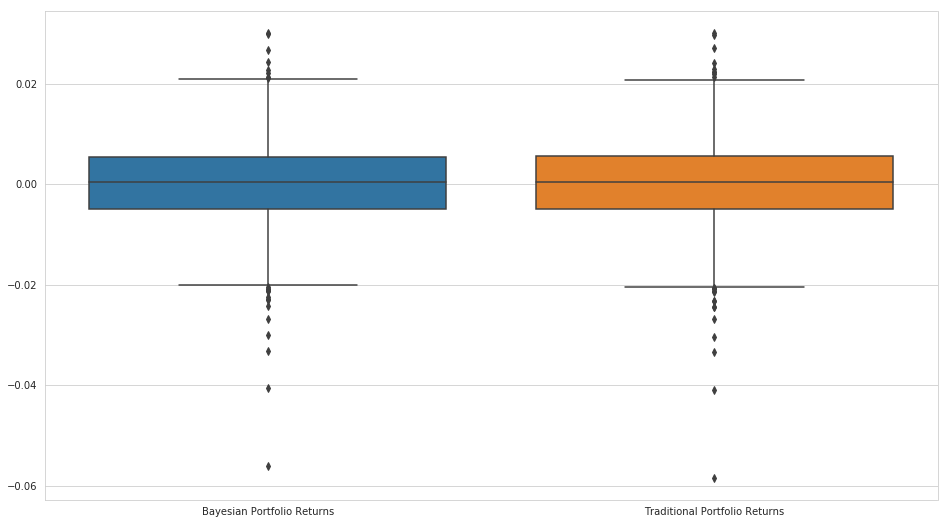

In [49]:
plt.figure(figsize=(16, 9))
sns.boxplot(
    data=pd.DataFrame(
        {'Traditional Portfolio Returns' : trad_weight_portfolio.values,
         'Bayesian Portfolio Returns': bayes_weight_portfolio.values}
    )
);

A typical way to compare two different return streams with different volatilities is to examine the Sharpe ratio. The Sharpe ratio is formulated as follows:

$$ \text{Sharpe ratio} = \frac{E[R_p] - R_f}{\sigma_p} $$

Where $E[R_p]$ is the expected return stream, $R_f$ is the risk free rate, and $\sigma_p$ is the volatility of the return stream. Here we assume that the risk free rate is $0$ and standardize the returns by the volatility of each "strategy".

In [50]:
trad_sharpe = trad_weight_portfolio.mean()/trad_weight_portfolio.std()
bayes_sharpe = bayes_weight_portfolio.mean()/bayes_weight_portfolio.std()

In [51]:
def rolling_sharpe(df, window):
    return df.rolling(window=window, center=False).mean()/df.rolling(window=window, center=False).std()

In [52]:
trad_rolling_sharpe = rolling_sharpe(trad_weight_portfolio, subsample_rate)
bayes_rolling_sharpe = rolling_sharpe(bayes_weight_portfolio, subsample_rate)

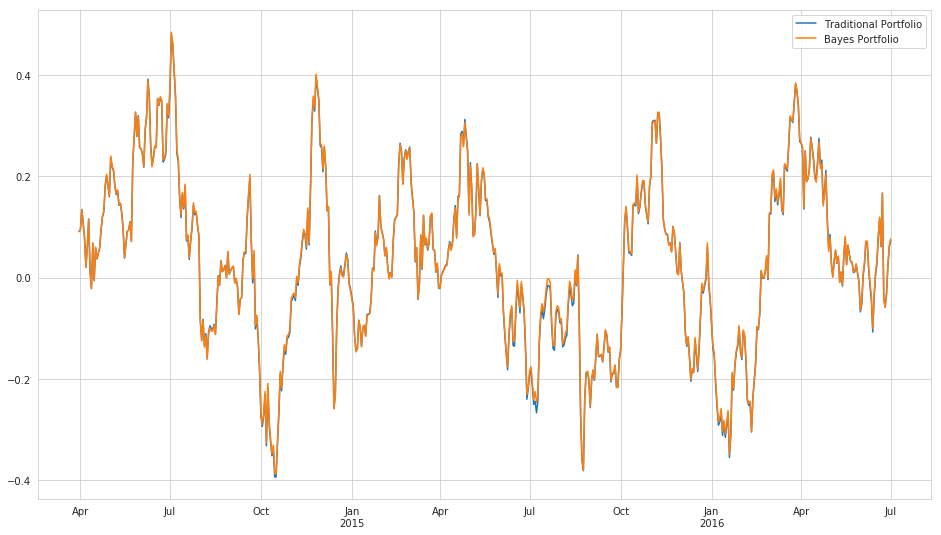

In [53]:
plt.figure(figsize=(16, 9))
trad_rolling_sharpe.plot()
bayes_rolling_sharpe.plot()
plt.legend();

The Sharpe ratios for each method are essentially equivalent.

In [54]:
print("Traditional Sharpe: {0}".format(trad_sharpe))
print("Bayes Sharpe: {0}".format(bayes_sharpe))

Traditional Sharpe: 0.009164938290031363
Bayes Sharpe: 0.011614755741102979


If we combine this information with the advantage in turnover afforded by the Bayesian formulation of the problem, we have reason to believe that this alternative model actually has some weight to it.

## Possible Improvements

This blog post represents a first foray into changing correlations. The model still leaves a few things to be desired. 

* Placing a random walk distribution on the Cholesky factors is weird - they don't have a straight-forward relationship to the individual elements in the covariance matrix we actually want to model.

* Prediction with random walks is not very good, a Gaussian process might be better.

* Maybe allow principal components of covariance matrix to change or assume a block structure to reduce dimensionality. 

* Compare against the Ledoit-Wolf Estimator instead of sample covariance.

* Scalability, in both number of securities and amount of time, is a major problem.